In [3]:
from typing import List, NamedTuple, Tuple, Union, Dict

import cytomine
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.colors import LinearSegmentedColormap
from msi_zarr_analysis.ml.dataset.cytomine_ms_overlay import get_overlay_annotations
from msi_zarr_analysis.ml.dataset.translate_annotation import (
    TemplateTransform,
    match_template_ms_overlay,
    rasterize_annotation_mapping,
    translate_parsed_annotation_mapping,
    scale_image,
    scale_annotation_mapping,
    get_cytomine_geometry,
)
from msi_zarr_analysis.utils.check import open_group_ro
from msi_zarr_analysis.utils.cytomine_utils import get_page_bin_indices
from msi_zarr_analysis.utils.autocrop import autocrop

import pathlib
import PIL
import shutil
import tifffile

from scripts.connect_from_json import connect, connect_with_params


class DSConfig(NamedTuple):
    image_id_overlay: int  # Cytomine ID for the overlay image
    local_overlay_path: str  # local path of the (downloaded) overlay
    lipid_tm: str  # name of the lipid to base the template matching on

    project_id: int  # project id
    annotated_image_id: int  # image with the annotations

    classes: Dict[str, List[int]]

    save_image: Union[bool, str] = False

    transform_rot90: int = 0
    transform_flip_ud: bool = False
    transform_flip_lr: bool = False

    annotation_users_id: Tuple[int] = ()  # select these users only

    zarr_template_path: str = None  # use another group for the template matching

In [4]:
config = DSConfig(
    **{
        "image_id_overlay": 545025763,
        "local_overlay_path": "../datasets/Adjusted_Cytomine_MSI_3103_Region013-Viridis-stacked.ome.tif",
        "lipid_tm": "LysoPPC",
        "project_id": 542576374,
        "annotated_image_id": 545025783,
        "transform_rot90": 1,
        "transform_flip_ud": True,
        "transform_flip_lr": False,
        "annotation_users_id": (),
        "zarr_template_path": "../datasets/comulis13_binned.zarr",
    },
    classes={  # both merged
        #"+": [544926081, 544924846],
        #"-": [544926097, 544926052],
        "LS": [544926097, 544926081],
        "SC": [544926052, 544924846],
    },
)

template_transform = TemplateTransform(
    rotate_90=config.transform_rot90,
    flip_lr=config.transform_flip_lr,
    flip_ud=config.transform_flip_ud,
)

lipid = "LysoPPC"
lipid_df_path = "../mz value + lipid name.csv"

group_binned = open_group_ro(config.zarr_template_path)

scale_factor = 5

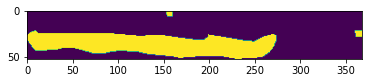

In [5]:
z_len = group_binned["/labels/lengths/0"]

presence_mask = z_len[0, 0] > 0
selection_tpl = autocrop(presence_mask)

presence_mask = presence_mask[selection_tpl]

plt.imshow(presence_mask)

In [6]:
lipids_planes = group_binned["/0"][(slice(None), 0) + selection_tpl]
#lipids_planes = group_binned["/0"][:, 0]
lipids_planes.shape # m/z Y X

(37, 53, 368)

In [7]:
cmap = "Wistia" if False else "viridis"

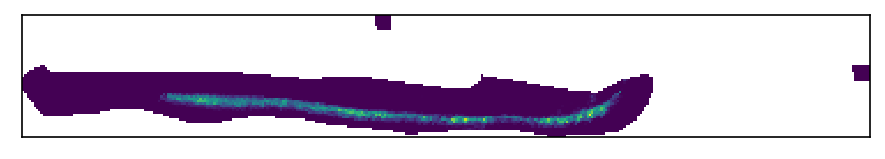

In [8]:
fig, ax = plt.subplots(dpi=150)
img = lipids_planes[14]
ax.imshow(np.where(presence_mask, img, np.nan), interpolation="nearest", cmap=cmap)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

fig.tight_layout()

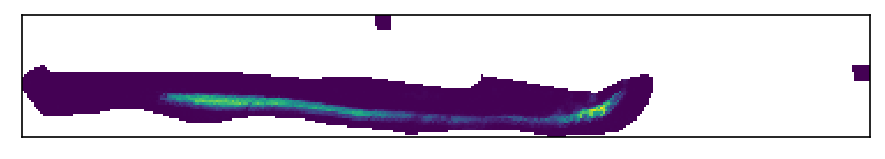

In [9]:
fig, ax = plt.subplots(dpi=150)
img = lipids_planes.sum(axis=0)
ax.imshow(np.where(presence_mask, img, np.nan), interpolation="nearest", cmap=cmap)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

fig.tight_layout()

In [ ]:
def save_as_stack_dir(dest: str, img: np.ndarray, cross_lipid_norm: bool):
    
    dest = pathlib.Path(dest)
    if dest.exists():
        shutil.rmtree(dest)
    dest.mkdir()

    img_max_val = img.max()
    background = img == 0
    
    planes = []
    for p in img:
        if cross_lipid_norm:
            p = p / img_max_val
        else:
            max_val = p.max()
            if max_val != 0:
                p = p / max_val
        color_map = plt.cm.ScalarMappable(cmap=plt.cm.viridis)
        planes.append(color_map.to_rgba(p, bytes=True, norm=False))
        del color_map
    
    assert img[~np.isnan(img)].max() == 0 or max([p.max() for p in planes]) > 0, img[~np.isnan(img)].max()
    
    stem = dest.stem

    for idx, p in enumerate(planes):
        #p[background[idx], 3] = 0
        p = p[..., :3]
        
        plane_path = dest / (stem + f"_{idx}.tiff")
        with tifffile.TiffWriter(plane_path) as tiff_writer:
            tiff_writer.write(p, photometric="RGB")

    return planes
del save_as_stack_dir

In [ ]:
#save_as_stack_dir("../region13-viridis-lipids-msi-inter-normalization.stack", lipids_planes, cross_lipid_norm=True)
#planes = save_as_stack_dir("../region13-viridis-lipids-msi-intra-normalization.stack", lipids_planes, cross_lipid_norm=False)

In [ ]:
def save_as_tiff(dest: str, img: np.ndarray, cross_lipid_norm: bool, scale_factor: int = None):
    img_max_val = img.max()
    background = ~presence_mask  # Y X
    
    suffix = ".ome.tiff"
    if dest[-len(suffix):] != suffix:
        raise ValueError("invalid path")
    
    planes = []
    for p in img:
        if cross_lipid_norm:
            p = p / img_max_val
        else:
            max_val = p.max()
            if max_val != 0:
                p = p / max_val
        color_map = plt.cm.ScalarMappable(cmap=plt.cm.viridis)
        
        p_rgba = color_map.to_rgba(p, bytes=True, norm=False)
        p_rgb = PIL.Image.fromarray(p_rgba, mode='RGBA').convert('RGB')
        p_rgb = np.array(p_rgb)
        
        p_rgb[background, :] = 0
        
        if scale_factor is not None:
            p_rgb = scale_image(p_rgb, scale_factor)
        
        planes.append(p_rgb)
        del color_map
    
    plane_np = np.stack(planes)  # Z Y X C
    plane_np = np.transpose(plane_np, (0, 3, 1, 2))  # Z C Y X

    with tifffile.TiffWriter(dest) as tiff_writer:
        compression = None
        # compression = "zlib"
        # compression = 34933 # PNG, see tifffile.py/class _TIFF/IMAGE_COMPRESSIONS
        # ZLIB AND PNG COMPRESSION ARE NOT SUPPORTED BY CYTOMINE
        tiff_writer.write(plane_np, photometric="RGB", metadata={'axes': 'ZCYX'}, compression=compression)
    
    return planes

In [ ]:
save_as_tiff(
    "../region13-viridis-lipids-msi-inter.ome.tiff",
    lipids_planes,
    cross_lipid_norm=True,
    scale_factor=scale_factor,
);

In [ ]:
planes = save_as_tiff(
    "../region13-viridis-lipids-msi-intra.ome.tiff",
    lipids_planes,
    cross_lipid_norm=False,
    scale_factor=scale_factor,
)

In [ ]:
lipids_planes.shape, planes[0].shape

In [10]:
connect("../config_cytomine.json")

[2022-09-28 14:17:59,131][INFO] [GET] [currentuser] CURRENT USER - 534530561 : mamodei | 200 OK


In [11]:
# template matching...
page_idx, bin_idx, *_ = get_page_bin_indices(
    image_id=config.image_id_overlay, lipid=lipid, csv_lipid_mz_path=lipid_df_path
)
print(f"{bin_idx=}")

[2022-09-28 14:18:00,463][INFO] [GET] [sliceinstance collection] 12 objects | 200 OK
bin_idx=14


In [12]:
annotation_dict = get_overlay_annotations(
    project_id=config.project_id,
    image_id=config.image_id_overlay,
    classes=config.classes,
    select_users=config.annotation_users_id,
)

[2022-09-28 14:18:03,640][INFO] [GET] [annotation collection] 396 objects | 200 OK
[2022-09-28 14:18:03,711][INFO] [GET] [imageinstance] 545025763 : Adjusted Cytomine MSI 3103/Region013-Viridis-stacked.ome.tif | 200 OK
[2022-09-28 14:18:03,825][INFO] [GET] [term collection] 35 objects | 200 OK


In [ ]:
matching_result, crop_idx = match_template_ms_overlay(
    group_binned,
    bin_idx,
    config.local_overlay_path,
    page_idx,
    template_transform,
)

In [ ]:
annotation_dict = translate_parsed_annotation_mapping(
    annotation_dict,
    template_transform,
    matching_result,
    (
        slice(crop_idx[0].start - selection_tpl[0].start, None),
        slice(crop_idx[1].start - selection_tpl[1].start, None),
    )
)  # VICTORY : these are the good annotations

In [ ]:
"""
annotation_dict = translate_parsed_annotation_mapping(
    annotation_dict,
    template_transform,
    matching_result,
    crop_idx,
)
""";

In [ ]:
annotation_dict = scale_annotation_mapping(
    annotation_dict,
    scale_factor,
)

In [ ]:
# get base image
# img = group_binned["/0"][bin_idx, 0]
img = planes[28]

In [ ]:
# rasterize annotations
full_shape = img.shape[:2]
raster_dict = rasterize_annotation_mapping(
    annotation_dict,
    full_shape,
)

In [ ]:
fig, ax = plt.subplots(dpi=150)

#img = template_transform.transform_template(img)

# plot img
#img[img < 200] = np.nan
#ax.imshow(img, interpolation="nearest", cmap="Wistia")
ax.imshow(img, interpolation="nearest")

# plot annotations
for color, (cls_label, annotation_lst) in zip(['tab:cyan', 'tab:purple'], raster_dict.items()):
    print(f"{cls_label}: {color}")
    
    min_val = min(a.raster.min() for a in annotation_lst) 
    max_val = max(a.raster.max() for a in annotation_lst)
    
    cmap = LinearSegmentedColormap.from_list(color, [
        (min_val, "#0000"),
        (max_val, color),
    ])

    for annotation in annotation_lst:
        #mask = template_transform.transform_template(annotation.raster)
        mask = annotation.raster
        ax.imshow(mask, alpha=0.8, cmap=cmap)

#ax.set_title(f"Annotated MSI: Region 13 {lipid}, LS/SC")
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

fig.tight_layout()

fig.savefig("annotated_crop_hires.png")

In [ ]:
raise Exception("cells below must be done manually")

In [ ]:
# unable to do it on the localhost server: just print all geometry as wkt

geometry_lst = []

for _, annotation_lst in annotation_dict.items():
    for parsed_annotation in annotation_lst:
        # annotation = parsed_annotation.annotation
        geometry = parsed_annotation.geometry
        geometry = get_cytomine_geometry(geometry, img.shape[0])
        geometry_lst.append(geometry.wkt)

In [ ]:
print(f"{geometry_lst=!r}")

In [20]:
project_id = 542576374
# image_id = 551298476
abstract_id = 551298088
#abstract_id = 551297671

In [21]:
slice_collection = cytomine.models.AbstractSliceCollection().fetch_with_filter("abstractimage", abstract_id)

[2022-09-28 14:19:50,694][INFO] [GET] [abstractslice collection] 37 objects | 200 OK


In [ ]:
#annotation_collection = cytomine.models.AnnotationCollection()

In [ ]:
"""for _, annotation_lst in annotation_dict.items():
    for parsed_annotation in annotation_lst:
        annotation = parsed_annotation.annotation

        geometry = parsed_annotation.geometry
        geometry = get_cytomine_geometry(geometry, img.shape[0])
        
        for slice_itm in slice_collection:

            tr_annotation = cytomine.models.Annotation(
                location=geometry.wkt,
                id_image=image_id,
                id_project=project_id,
                id_slice=slice_itm.id,
                term=annotation.term
            )
            annotation_collection.append(tr_annotation)
""";

In [ ]:
#annotation_collection.save()

In [15]:
lipids_df = pd.read_csv(lipid_df_path, sep=None, engine="python")

In [16]:
lipids_df.head()

,m/z,Interval Width (+/- Da),Name,Unnamed: 3
0,205.19508,0.00045,X-X-x-farnesene,NaN
1,243.26824,0.00053,hexadecanol,NaN
2,285.27881,0.00062,hexcadecyl acetate,NaN
3,305.24751,0.00067,AA,NaN
4,317.21112,0.00069,15d PGJ2,NaN


In [17]:
lipids_df.iloc[3]

m/z                        305.24751
Interval Width (+/- Da)      0.00067
Name                              AA
Unnamed: 3                       NaN
Name: 3, dtype: object

In [18]:
image_id

NameError: name 'image_id' is not defined

In [ ]:
#slice_collection = cytomine.models.SliceInstanceCollection().fetch_with_filter("imageinstance", image_id)!

In [22]:
for slice_instance in slice_collection:
    if slice_instance.zName is not None:
        print(f"skipping {slice_instance.zName=} {slice_instance.zStack=}")
        continue
    slice_instance.zName = lipids_df.iloc[slice_instance.zStack].Name
    slice_instance.update()

[2022-09-28 14:20:00,252][INFO] [PUT] [abstractslice] 551298094 : None | 200 OK
[2022-09-28 14:20:00,358][INFO] [PUT] [abstractslice] 551298100 : None | 200 OK
[2022-09-28 14:20:00,446][INFO] [PUT] [abstractslice] 551298106 : None | 200 OK
[2022-09-28 14:20:00,532][INFO] [PUT] [abstractslice] 551298112 : None | 200 OK
[2022-09-28 14:20:00,625][INFO] [PUT] [abstractslice] 551298118 : None | 200 OK
[2022-09-28 14:20:00,717][INFO] [PUT] [abstractslice] 551298136 : None | 200 OK
[2022-09-28 14:20:00,805][INFO] [PUT] [abstractslice] 551298156 : None | 200 OK
[2022-09-28 14:20:00,894][INFO] [PUT] [abstractslice] 551298173 : None | 200 OK
[2022-09-28 14:20:00,998][INFO] [PUT] [abstractslice] 551298196 : None | 200 OK
[2022-09-28 14:20:01,109][INFO] [PUT] [abstractslice] 551298214 : None | 200 OK
[2022-09-28 14:20:01,195][INFO] [PUT] [abstractslice] 551298232 : None | 200 OK
[2022-09-28 14:20:01,290][INFO] [PUT] [abstractslice] 551298249 : None | 200 OK
[2022-09-28 14:20:01,371][INFO] [PUT] [a